In [4]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csc_matrix

In [5]:
def make_sparse_spd_matrix(
    n_dim=10,
    alpha=0.95,
    norm_diag=False,
    smallest_coef=0.1,
    largest_coef=0.9,
    random_state=None
):
    """
    Generate a sparse symmetric positive definite (SPD) matrix.

    Parameters
    ----------
    n_dim : int, default=10
        The size of the random matrix to generate.

    alpha : float, default=0.95
        The probability that a coefficient is zero, controlling sparsity.
        Higher values mean more sparsity. Should be between 0 and 1.

    norm_diag : bool, default=False
        If True, normalizes the matrix so that the diagonal elements are all 1.

    smallest_coef : float, default=0.1
        The smallest coefficient in the randomly generated values (between 0 and 1).

    largest_coef : float, default=0.9
        The largest coefficient in the randomly generated values (between 0 and 1).

    random_state : int or None, default=None
        Seed for random number generation, ensuring reproducible results.

    Returns
    -------
    ndarray or sparse matrix
        The generated sparse SPD matrix as a dense ndarray.
    """
    rng = np.random.default_rng(random_state)

    # Start with a negative identity matrix, which will form the basis of the Cholesky factor.
    chol = -sp.eye(n_dim, format="csc")

    # Generate a random sparse lower triangular matrix to add sparsity
    aux = sp.random(
        m=n_dim, n=n_dim, density=1 - alpha,
        data_rvs=lambda x: rng.uniform(low=smallest_coef, high=largest_coef, size=x),
        format="csc"
    )
    aux = sp.tril(aux, k=-1, format="csc")

    # Randomly permute rows and columns to avoid asymmetries
    permutation = rng.permutation(n_dim)
    aux = aux[permutation].T[permutation]

    # Add the sparse auxiliary matrix to the Cholesky factor
    chol += aux

    # Form the SPD matrix by taking the product of the Cholesky factor with its transpose
    prec = chol.T @ chol

    # Optionally normalize the diagonal to 1
    if norm_diag:
        d = sp.diags(1.0 / np.sqrt(prec.diagonal()))
        prec = d @ prec @ d

    return prec.toarray()


In [6]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sparse
from scipy.linalg import solve_sylvester, norm

# Fix random number generator for reproducibility
np.random.seed(0)

In [7]:
def generate_sparse_covariance(n, N, alpha=0.8, random_state=42):
    """
    Generate a sparse inverse covariance matrix B, compute its associated covariance matrix E,
    and generate N samples from a multivariate normal distribution with covariance E.

    Parameters:
    - n (int): Dimension of the matrix.
    - N (int): Number of samples to generate.
    - alpha (float): Sparsity level for the sparse SPD matrix.
    - random_state (int): Random seed for reproducibility.

    Returns:
    - B (np.ndarray): Sparse inverse covariance matrix (precision matrix).
    - Strue (np.ndarray): True inverse covariance matrix (squared B).
    - E (np.ndarray): Covariance matrix (inverse of Strue).
    - y_samples (np.ndarray): Generated samples following N(0, E).
    - S (np.ndarray): Sample covariance matrix from the generated samples.
    """
    # Create sparse inverse covariance matrix (B)
    B = make_sparse_spd_matrix(n_dim=n, alpha=alpha, norm_diag=True, random_state=random_state)

    # Compute true inverse covariance matrix (Strue)
    Strue = np.linalg.matrix_power(B, 2)

    # Compute covariance matrix (E)
    E = np.linalg.inv(Strue)

    # Generate N samples Y ~ N(0, E)
    y_samples = la.sqrtm(E).dot(np.random.randn(n, N))

    # Calculate sample covariance matrix
    S = np.cov(y_samples)

    return B, Strue, E, y_samples, S


In [8]:
def newton_nare(A, B, C, D, X0, tol=1e-13, kmax=30):
    """
    Newton's method for solving the Nonlinear Algebraic Riccati Equation (NARE):
    C + XA + DX - XBX = 0
    """
    X = X0.copy()
    k = 0
    err = 1

    while err > tol and k < kmax:
        # Compute residual RX = C + XA + DX - XBX
        RX = C + X @ A + D @ X - X @ B @ X

        # Solve the Sylvester equation (D - XB)H + H(A - BX) = -RX for H
        H = solve_sylvester(D - X @ B, A - B @ X, -RX)

        # Update X
        X = X + H

        # Calculate the error
        err = norm(H, 1) / norm(X, 1)

        # Increment iteration counter
        k += 1

    # Check if the solution converged
    if k == kmax:
        print("Warning: reached the maximum number of iterations without convergence.")

    return X

In [9]:
# Soft thresholding function
def soft_thresholding(x, threshold):
    """Applies soft-thresholding elementwise."""
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

In [10]:

# ADMM Algorithm for Elastic-Net Penalized Precision Matrix Estimation
def admm_precision_matrix(S, lambda_, alpha, rho=1.0, max_iter=100, tol=1e-4):
    """
    ADMM algorithm for precision matrix estimation with elastic-net penalty.
    """
    n = S.shape[0]
    Z = np.zeros((n, n))
    Lambda = np.zeros((n, n))
    I = np.eye(n)  # Identity matrix

    # Initial B (can be initialized as identity matrix)
    B = np.eye(n)

    for k in range(max_iter):
        # Step 1: Update B using Newton NARE
        # Here, we set up the matrices to solve the NARE: A3 + XA1 + A4X - XA2X = 0
        A3 = - 2 * I
        A4 = Lambda - rho * Z
        A1 = 0 * I
        A2 = - (2 * S + rho * I)
        X0 = B  # Initial guess for Newton NARE

        # Solve for the new B using Newton NARE
        B_new = newton_nare(A1, A2, A3, A4, X0)

        # Step 2: Update Z elementwise using soft-thresholding
        Z_new = soft_thresholding(rho * B_new + Lambda, lambda_)
        Z_new = Z_new / rho

        # Step 3: Update Lambda (Lagrange multiplier)
        Lambda_new = Lambda + rho * (B_new - Z_new)

        # Check convergence
        if np.linalg.norm(B_new - B, ord='fro') < tol:
            print(f"Converged after {k+1} iterations.")
            break

        # Update for the next iteration
        B, Z, Lambda = B_new, Z_new, Lambda_new

    return B

In [11]:
#Thresholding B_estimate
def hard_threshold(B_estimate,threshold):
  return np.where(np.abs(B_estimate) > threshold, B_estimate, 0)

In [12]:
n = 10
N = 100
B, Strue, E, y_samples, S = generate_sparse_covariance(n, N)

# Parameters for the elastic-net penalty and ADMM algorithm
lambda_ = 0.194  # Regularization strength
alpha = 1  # Mixing parameter (0 = Ridge, 1 = Lasso)
rho = 1.0  # ADMM penalty parameter
max_iter = 100  # Maximum number of iterations
tol = 1e-4  # Convergence tolerance

# Run the ADMM algorithm using the generated sample covariance matrix
B_estimate = admm_precision_matrix(S, lambda_, alpha, rho, max_iter, tol)

print("Estimated Precision Matrix (B estimate):")
print(B_estimate)

#print(B_estimate @ B_estimate)

# Make the estimated precision matrix symmetric
B_estimate = (B_estimate + B_estimate.T) / 2

# Verify the symmetry and print the adjusted B_estimate
print("Symmetric Estimated Precision Matrix (B estimate):")
print(B_estimate)

# Test the matrix by computing its square
#print("B_estimate @ B_estimate (should approximate the inverse covariance matrix):")
#print(B_estimate @ B_estimate)

Converged after 58 iterations.
Estimated Precision Matrix (B estimate):
[[ 8.15623392e-01  4.82672540e-05 -4.55276708e-01  1.34197512e-01
  -6.35834586e-02 -7.79987792e-04 -3.04281179e-01  1.89868025e-01
  -2.50657377e-04  2.81095623e-02]
 [ 6.43929637e-03  9.75770481e-01  1.37838311e-05 -3.55516390e-02
   7.98768390e-07  6.73760428e-03 -3.91509750e-06  1.17100851e-05
   3.34967246e-02  7.59102129e-08]
 [-4.61856379e-01  3.02696448e-05  7.97365300e-01 -2.98196191e-01
  -2.87799175e-03  1.31359814e-04  6.62136959e-05 -3.29175455e-01
  -4.65531810e-05 -5.69954306e-05]
 [ 1.33768106e-01 -2.97156842e-02 -2.98335073e-01  8.61011940e-01
  -3.25962949e-03 -4.47769225e-06  3.89148280e-02 -2.66797474e-01
  -4.28109534e-02 -2.49131386e-05]
 [-4.66086498e-02  2.38281477e-06 -3.55616019e-02 -9.41820007e-03
   9.53763450e-01 -2.63207624e-02  2.63535521e-02 -2.56885394e-06
  -8.88916559e-03  1.47560400e-03]
 [-9.47469789e-05  5.95581652e-03  1.09368409e-04  2.08507950e-04
  -2.11153725e-02  8.281354

In [13]:
B_estimate = hard_threshold(B_estimate , 0.01)

Plotting results

In [14]:
import matplotlib.pyplot as plt

Minimum eigenvalue: 0.17447327709166205


<Figure size 640x480 with 0 Axes>

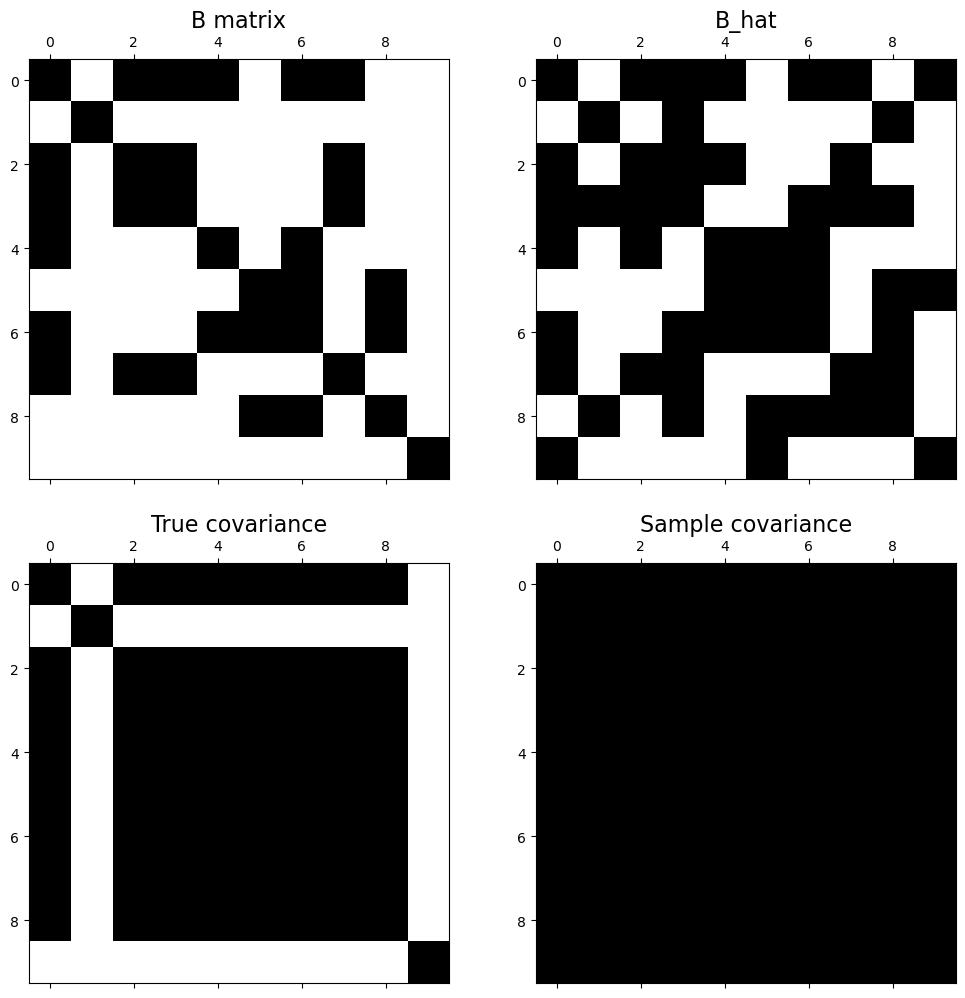

In [15]:
# Create figure.
plt.figure()
plt.figure(figsize=(12, 12))

# Plot sparsity pattern for B matrix.
plt.subplot(2, 2, 1)
plt.spy(B)
plt.title('B matrix', fontsize=16)

# Plot sparsity pattern for Omega/Strue matrix.
plt.subplot(2, 2, 2)
plt.spy(B_estimate)
plt.title('B_hat', fontsize=16)

# Plot sparsity pattern for Sample covariance matrix.
plt.subplot(2, 2, 3)
plt.spy(E)
plt.title('True covariance', fontsize=16)

# Plot sparsity pattern for Sample covariance matrix.
plt.subplot(2, 2, 4)
plt.spy(S)
plt.title('Sample covariance', fontsize=16)

eigenvalues = np.linalg.eigvals(B)
min_eigenvalue = np.min(eigenvalues)
print("Minimum eigenvalue:", min_eigenvalue)

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
def evaluate_metrics_vs_lambda(B, lambda_values, alpha=1, rho=1.0, max_iter=100, tol=1e-4, threshold=1e-4):

    metrics = {
        "lambda": [],
        "accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    for lambda_ in lambda_values:
        # Compute the estimated precision matrix
        B_estimate = admm_precision_matrix(B, lambda_, alpha, rho, max_iter, tol)

        # Apply thresholding to B_estimate only
        B_estimate_thresholded = hard_threshold(B_estimate, threshold)

        # Flatten ground truth and thresholded estimate for comparison
        ground_truth = (B != 0).astype(int).flatten()  # Non-zero is Class 1, Zero is Class 0
        predicted = (B_estimate_thresholded != 0).astype(int).flatten()

        # Calculate metrics
        accuracy = accuracy_score(ground_truth, predicted)
        precision = precision_score(ground_truth, predicted)
        recall = recall_score(ground_truth, predicted)
        f1 = f1_score(ground_truth, predicted)

        # Store metrics
        metrics["lambda"].append(lambda_)
        metrics["accuracy"].append(accuracy)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["f1_score"].append(f1)

    return metrics

Converged after 23 iterations.
Converged after 25 iterations.
Converged after 25 iterations.
Converged after 31 iterations.
Converged after 32 iterations.
Converged after 32 iterations.
Converged after 31 iterations.
Converged after 31 iterations.
Converged after 32 iterations.
Converged after 32 iterations.
Converged after 33 iterations.
Converged after 33 iterations.
Converged after 35 iterations.
Converged after 39 iterations.
Converged after 40 iterations.
Converged after 41 iterations.
Converged after 42 iterations.
Converged after 42 iterations.
Converged after 42 iterations.
Converged after 44 iterations.
Metrics vs Lambda:
      lambda  accuracy  precision    recall  f1_score
0   0.100000      0.90   0.772727  1.000000  0.871795
1   0.147368      0.90   0.772727  1.000000  0.871795
2   0.194737      0.94   0.850000  1.000000  0.918919
3   0.242105      0.83   0.680851  0.941176  0.790123
4   0.289474      0.84   0.714286  0.882353  0.789474
5   0.336842      0.81   0.702703  0.

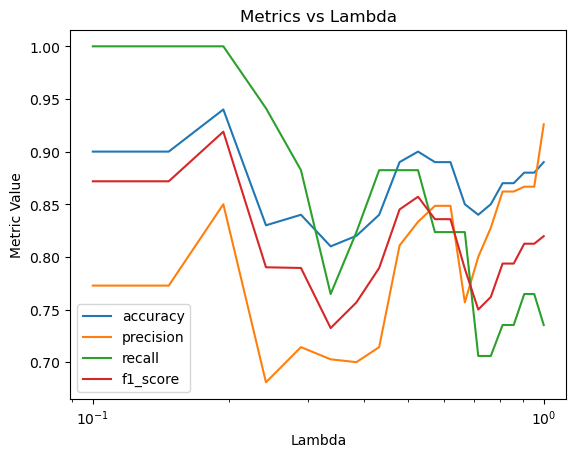

In [17]:
lambda_values = np.linspace(0.1, 1, 20)  # 20 values from 0.1 to 1.0

metrics = evaluate_metrics_vs_lambda(B, lambda_values)

import pandas as pd

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(metrics)

print("Metrics vs Lambda:")
print(metrics_df)

# Plotting metrics vs. lambda
import matplotlib.pyplot as plt

for metric in ["accuracy", "precision", "recall", "f1_score"]:
    plt.plot(metrics["lambda"], metrics[metric], label=metric)
plt.xscale("log")
plt.xlabel("Lambda")
plt.ylabel("Metric Value")
plt.title("Metrics vs Lambda")
plt.legend()
plt.show()